<a href="https://colab.research.google.com/github/AyushiM1102/Electra_classification_fake_vs_real_news/blob/main/bert_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
!pip install transformers

In [2]:
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 418 kB 7.0 MB/s 


In [3]:
import pandas as pd
import torch
import numpy as np
from transformers import BertTokenizer, BertModel
from torch import nn
from torchmetrics import Accuracy, F1Score
from torch.optim import Adam
from tqdm import tqdm

In [4]:
!git clone https://github.com/AyushiM1102/Electra_classification_fake_vs_real_news.git

Cloning into 'Electra_classification_fake_vs_real_news'...
remote: Enumerating objects: 75, done.
remote: Total 75 (delta 0), reused 0 (delta 0), pack-reused 75
Unpacking objects: 100% (75/75), done.


In [5]:
!unzip /content/Electra_classification_fake_vs_real_news/data/WELFake_Dataset.csv.zip -d /content/Electra_classification_fake_vs_real_news/dataset

Archive:  /content/Electra_classification_fake_vs_real_news/data/WELFake_Dataset.csv.zip
  inflating: /content/Electra_classification_fake_vs_real_news/dataset/WELFake_Dataset.csv  
  inflating: /content/Electra_classification_fake_vs_real_news/dataset/__MACOSX/._WELFake_Dataset.csv  


In [6]:
datapath = f'/content/Electra_classification_fake_vs_real_news/dataset/WELFake_Dataset.csv'
df = pd.read_csv(datapath)
df.head()

,Unnamed: 0,title,text,label
0,0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1
1,1,NaN,Did they post their votes for Hillary already?,1
2,2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1
3,3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0
4,4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1


In [7]:
df["text"] = df["text"].astype(str)
df.text.dtype

dtype('O')

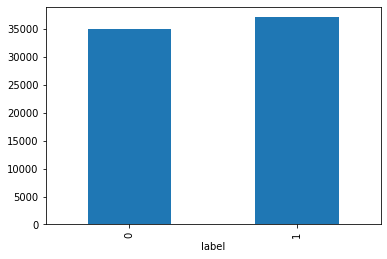

In [8]:
# Drop NaN and see class balance
df = df[df['label'].notna()]
df.groupby(['label']).size().plot.bar()

In [9]:
df.label[df.label == 0] = 'real'
df.label[df.label == 1] = 'fake'

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [10]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
labels = {'real':0,'fake':1}

class Dataset(torch.utils.data.Dataset):

    def __init__(self, df):

        self.labels = [labels[label] for label in df['label']]
        self.texts = [tokenizer(text, 
                               padding='max_length', max_length = 512, truncation=True,
                                return_tensors="pt") for text in df['text']]

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs

        return self.texts[idx]

    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_texts, batch_y

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [11]:
class BertClassifier(nn.Module):

    def __init__(self, dropout=0.5):

        super(BertClassifier, self).__init__()

        self.bert = BertModel.from_pretrained('bert-base-cased')
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, 5)
        self.relu = nn.ReLU()

    def forward(self, input_id, mask):

        _, pooled_output = self.bert(input_ids= input_id, attention_mask=mask,return_dict=False)
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        final_layer = self.relu(linear_output)

        return final_layer

In [12]:
def train(model, train_data, val_data, learning_rate, epochs):

    train, val = Dataset(train_data), Dataset(val_data)

    train_dataloader = torch.utils.data.DataLoader(train, batch_size=2, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr= learning_rate)
    

    if use_cuda:

            model = model.cuda()
            criterion = criterion.cuda()

    for epoch_num in range(epochs):

            total_acc_train = 0
            total_loss_train = 0
            total_TP_train = 0
            total_FP_train = 0
            total_FN_train = 0

            for train_input, train_label in tqdm(train_dataloader):

                train_label = train_label.to(device)
                mask = train_input['attention_mask'].to(device)
                input_id = train_input['input_ids'].squeeze(1).to(device)

                output = model(input_id, mask)
                
                batch_loss = criterion(output, train_label)
                total_loss_train += batch_loss.item()
                
                # Metrics calculation for training
                TP = ((output.argmax(dim=1) == 1) & (train_label == 1)).sum()
                FP = ((output.argmax(dim=1) == 1) & (train_label == 0)).sum()
                FN = ((output.argmax(dim=1) == 0) & (train_label == 1)).sum()
                acc = (output.argmax(dim=1) == train_label).sum().item()

                total_acc_train += acc
                total_TP_train += TP
                total_FP_train += FP
                total_FN_train += FN

                model.zero_grad()
                batch_loss.backward()
                optimizer.step()
            
            total_acc_val = 0
            total_loss_val = 0
            total_TP_val = 0
            total_FP_val = 0
            total_FN_val = 0

            with torch.no_grad():

                for val_input, val_label in val_dataloader:

                    val_label = val_label.to(device)
                    mask = val_input['attention_mask'].to(device)
                    input_id = val_input['input_ids'].squeeze(1).to(device)

                    output = model(input_id, mask)

                    batch_loss = criterion(output, val_label)
                    total_loss_val += batch_loss.item()
                    
                    # Metrics calculation for validation
                    acc = (output.argmax(dim=1) == val_label).sum().item()
                    TP = ((output.argmax(dim=1) == 1) & (val_label == 1)).sum()
                    FP = ((output.argmax(dim=1) == 1) & (val_label == 0)).sum()
                    FN = ((output.argmax(dim=1) == 0) & (val_label == 1)).sum()

                    total_acc_val += acc
                    total_TP_val += TP
                    total_FP_val += FP
                    total_FN_val += FN
            
            print(f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(train_data): .3f} | Train Accuracy: {total_acc_train / len(train_data): .3f} | Train Precision: {total_TP_train / (total_TP_train + total_FP_train): .3f} | Train Recall: {total_TP_train / (total_TP_train + total_FN_train): .3f} | Train F1: {total_TP_train / (total_TP_train + 0.5*(total_FN_train+total_FP_train)): .3f}')
            print(f'Epochs: {epoch_num + 1} | Val Loss: {total_loss_val / len(val_data): .3f} | Val Accuracy: {total_acc_val / len(val_data): .3f} | Val Precision: {total_TP_val / (total_TP_val + total_FP_val): .3f} | Val Recall: {total_TP_val / (total_TP_val + total_FN_val): .3f} | Val F1: {total_TP_val / (total_TP_val + 0.5*(total_FN_val + total_FP_val)): .3f}')


In [13]:

def evaluate(model, test_data):

    test = Dataset(test_data)

    test_dataloader = torch.utils.data.DataLoader(test, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:

        model = model.cuda()

    total_acc_test = 0
    total_TP_test = 0
    total_FP_test = 0
    total_FN_test = 0

    with torch.no_grad():

        for test_input, test_label in test_dataloader:

              test_label = test_label.to(device)
              mask = test_input['attention_mask'].to(device)
              input_id = test_input['input_ids'].squeeze(1).to(device)

              output = model(input_id, mask)
              
              # Metrics calculation for test
              acc = (output.argmax(dim=1) == test_label).sum().item()
              TP = ((output.argmax(dim=1) == 1) & (test_label == 1)).sum()
              FP = ((output.argmax(dim=1) == 1) & (test_label == 0)).sum()
              FN = ((output.argmax(dim=1) == 0) & (test_label == 1)).sum()

              total_acc_test += acc
              total_TP_test += TP
              total_FP_test += FP
              total_FN_test += FN
    
    print(f'Test Accuracy: {total_acc_test / len(test_data): .3f} | Test Precision: {total_TP_test / (total_TP_test + total_FP_test): .3f} | Test Recall: {total_TP_test / (total_TP_test + total_FN_test): .3f} | Test F1: {total_TP_test / (total_TP_test + 0.5*(total_FN_test + total_FP_test)): .3f}')


In [14]:
np.random.seed(115)

# Check % splitting
df_train, df_val, df_test = np.split(df.sample(frac=1, random_state=42),[int(.8*len(df)), int(.9*len(df))])

print(len(df_train),len(df_val), len(df_test))

57707 7213 7214


In [ ]:
EPOCHS = 5
model = BertClassifier()
LR = 1e-6
              
train(model, df_train, df_val, LR, EPOCHS)

Downloading:   0%|          | 0.00/416M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
evaluate(model, df_test)